# Importing Libraries

In [42]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
from torch import nn
import matplotlib.pyplot as plt

## Checking for GPU for training

In [43]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

In [44]:
train_data_path = '/Users/stephenkullman/Desktop/archive/train/asl_alphabet_train'


## Normalizing Inputs

In [45]:
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [46]:
%%time
train_dataset = datasets.ImageFolder(train_data_path, transform=train_transforms)

CPU times: user 77 ms, sys: 61.6 ms, total: 139 ms
Wall time: 382 ms


In [47]:
%%time
val_dataset = datasets.ImageFolder(train_data_path, transform=test_transforms)

CPU times: user 74 ms, sys: 38.4 ms, total: 112 ms
Wall time: 112 ms


In [48]:
torch.manual_seed(1)
# num_train_samples = len(train_dataset)
num_train_samples = 20000

val_split = 0.2
split = int(num_train_samples * val_split)
indices = torch.randperm(num_train_samples)


train_subset = torch.utils.data.Subset(train_dataset, indices[split:])
val_subset = torch.utils.data.Subset(val_dataset, indices[:split])

len(train_subset), len(val_subset)

(16000, 4000)

## Creating Dataloaders

In [49]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_subset, 
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_subset,
    batch_size=batch_size,
    shuffle=False
)

In [50]:
classes = train_dataloader.dataset.dataset.classes

torch.Size([32, 3, 224, 224]) torch.Size([32])
True Label C


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


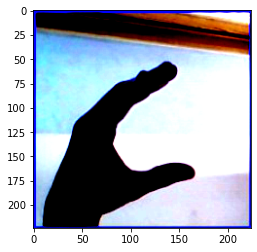

In [51]:
for img, label in train_dataloader:
    print(img.shape, label.shape)
    print(f'True Label {classes[label[0]]}')
    plt.imshow(img[0].permute(1, 2, 0))
    break

## Model Building - Pre-trained

In [52]:
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights

In [53]:
lr = .001

model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.to(mps_device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [54]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [55]:
from time import time


def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses = [], []


    model.to(mps_device)


    for epoch in range(num_epoch):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(mps_device)
            labels = labels.to(mps_device)

            model.train()

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train Loss: {running_loss / steps:.3f}.', end=' ')
                print(f'Train Accuracy: {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(mps_device)
                        labels = labels.to(mps_device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val Loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time}') 
        #torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
        
    return model, train_losses, val_losses

In [56]:
print_every = 50
num_epoch = 2

resnet, train_losses, val_losses = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    print_every=print_every,
    num_epoch=num_epoch
)

Epoch [1]/[2]. Batch [50]/[500]. Train Loss: 0.518. Train Accuracy: 90.625. Val Loss 0.523. Val acc 87.100. Took 451.012 seconds
Epoch [1]/[2]. Batch [100]/[500]. Train Loss: 0.298. Train Accuracy: 94.312. Val Loss 0.298. Val acc 92.675. Took 407.419 seconds
Epoch [1]/[2]. Batch [150]/[500]. Train Loss: 0.214. Train Accuracy: 95.750. Val Loss 0.494. Val acc 87.175. Took 310.761 seconds
Epoch [1]/[2]. Batch [200]/[500]. Train Loss: 0.172. Train Accuracy: 96.469. Val Loss 0.012. Val acc 99.600. Took 320.172 seconds
Epoch [1]/[2]. Batch [250]/[500]. Train Loss: 0.146. Train Accuracy: 96.950. Val Loss 0.020. Val acc 99.475. Took 341.731 seconds
Epoch [1]/[2]. Batch [300]/[500]. Train Loss: 0.124. Train Accuracy: 97.385. Val Loss 0.001. Val acc 100.000. Took 292.688 seconds
Epoch [1]/[2]. Batch [350]/[500]. Train Loss: 0.119. Train Accuracy: 97.446. Val Loss 0.098. Val acc 96.750. Took 295.182 seconds
Epoch [1]/[2]. Batch [400]/[500]. Train Loss: 0.106. Train Accuracy: 97.711. Val Loss 0.00

In [58]:
torch.save(model.state_dict(), '/Users/stephenkullman/Desktop/School of Data Science/Deep Learning/Project.pth')

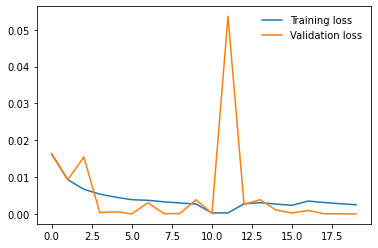

In [57]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()